# CS 4320 Final Project

In [821]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

## Read in data
---

In [822]:
train=pd.read_csv('data/train.csv',parse_dates=['date'],
                  dtype={'store_nbr':'int8', 'family':'category', 'sales':'float32',
                        'onpromotion':'int16','id':'int32'} ,infer_datetime_format= True)
                        
test=pd.read_csv('data/test.csv',parse_dates=['date'],
                 dtype={'store_nbr':'int8', 'family':'category','onpromotion':'int16','id':'int32'},
                 infer_datetime_format= True)

oil = pd.read_csv("data/oil.csv", parse_dates=['date'])
holidays_events = pd.read_csv("data/holidays_events.csv", parse_dates=['date'])
transactions = pd.read_csv("data/transactions.csv", parse_dates=['date'])
stores = pd.read_csv("data/stores.csv")

le = LabelEncoder()

## Pre Analysis of sales/transaction trends
---

In [823]:
train_ext = train.merge(stores, on='store_nbr', how='left')
train_ext['date'] = train_ext['date'].astype('datetime64[ns]')
transactions['date'] = transactions['date'].astype('datetime64[ns]')
train_ext = train_ext.merge(transactions, on=['date', 'store_nbr'], how='left')
train_ext['date'] = train_ext.date.dt.to_period('D')
# transactions['date'] = transactions.date.dt.to_period('D')
# train_ext = train_ext.rename(columns={"type": "store_type"})
train_ext = train_ext.set_index(['date']).sort_index()

Plotting the sales and transaction data over the course of the training set we see clear yearly and monthly trends. There are spikes for, presumably, pay periods and christmas time. This is something we want to capture when predicting sales

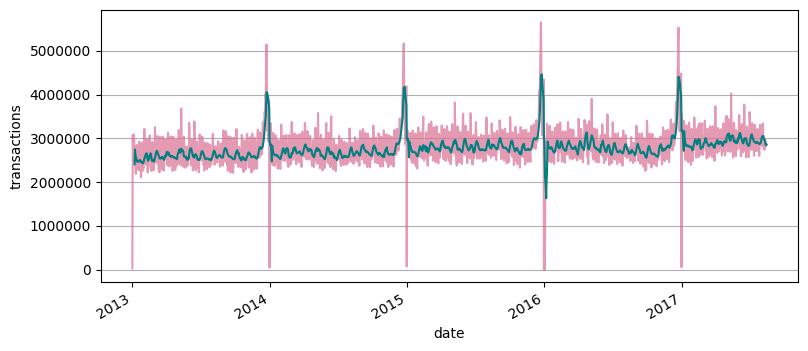

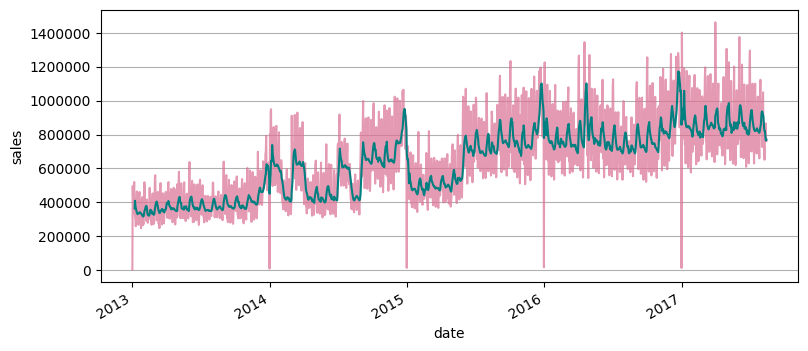

In [824]:
#weekly average of sales
sales_data=train.groupby('date').agg({'sales':'sum'}).reset_index()
sales_data['sales_average'] = sales_data['sales'].rolling(7).mean()

sales_data_reg = sales_data.set_index(['date']).sort_index().drop('sales_average', axis=1)
sales_data_avg = sales_data.set_index(['date']).sort_index().drop('sales', axis=1)


#weekly average of transactions
trans_data=train_ext.groupby('date').agg({'transactions':'sum'}).reset_index()
trans_data['transactions_average'] = trans_data['transactions'].rolling(7).mean()
trans_data['date'] = trans_data['date'].dt.to_timestamp()

trans_data_reg = trans_data.set_index(['date']).sort_index().drop('transactions_average', axis=1)
trans_data_avg = trans_data.set_index(['date']).sort_index().drop('transactions', axis=1)

# plot the roc curve for the model
f = plt.figure()
f.set_figwidth(9)
f.set_figheight(4)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(visible=True, which='major', axis='y')
plt.plot(trans_data_reg, 'palevioletred', alpha=0.7)
plt.plot(trans_data_avg, 'teal')
plt.gcf().autofmt_xdate()
plt.xlabel('date')
plt.ylabel('transactions')
plt.show()


f = plt.figure()
f.set_figwidth(9)
f.set_figheight(4)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(visible=True, which='major', axis='y')
plt.plot(sales_data_reg, 'palevioletred', alpha=0.7)
plt.plot(sales_data_avg, 'teal')
plt.gcf().autofmt_xdate()
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

Averaging the amount of transactions throughout each day of the week we can also see clear weekly patterns on how much people buy on what days.

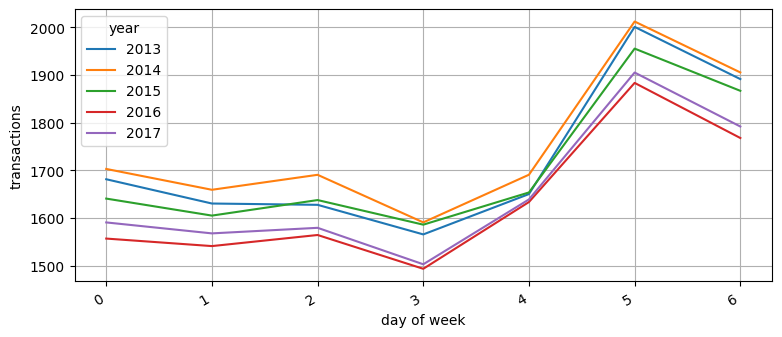

In [825]:
temp=transactions.copy()
temp['year']=temp.date.dt.year
temp['month']=temp.date.dt.month
temp['dayofweek']=temp.date.dt.dayofweek
temp=temp.groupby(['year','dayofweek'])['transactions'].mean().reset_index()
# px.line(temp.reset_index(),x='dayofweek',train_Y='transactions',color='year')
temp = temp.pivot(index='dayofweek', columns='year', values='transactions')

temp.plot(figsize=(9,4), grid=True)
plt.gcf().autofmt_xdate()
plt.xlabel('day of week')
plt.ylabel('transactions')
plt.show()

## Preprocessing
---

### <u>Calendar</u>

We want to contruct a calendar with data of the individual days, data on whether it's a holiday, workday, what day of week, month etc.

Load holidays and only include national holidays

In [826]:
holidays = holidays_events[holidays_events.locale=='National']
holidays = holidays.set_index('date').sort_index()
holidays.index = holidays.index.to_period('D')
# keep only one event per day
holidays = holidays.groupby(holidays.index).first()
holidays.drop(columns=['locale', 'locale_name', 'description'], inplace=True)
holidays.head()

,type,transferred
date,,
2012-08-10,Holiday,False
2012-10-09,Holiday,True
2012-10-12,Transfer,False
2012-11-02,Holiday,False
2012-11-03,Holiday,False


Calc whether the date is a workday or not

In [827]:
def compute_workdays(df):
    df['workday'] = True
    df.loc[df['weekday'] > 4, 'workday'] = False
    df.loc[df.type=='Bridge', 'workday'] = False
    df.loc[df.type=='Work Day', 'workday'] = True
    df.loc[df.type=='Transfer', 'workday'] = False
    df.loc[(df.type=='Holiday')&(df.transferred==False), 'workday'] = False
    df.loc[(df.type=='Holiday')&(df.transferred==True ), 'workday'] = True
    return df

Create a calendar of events and date information for the training and test sets.

In [828]:
calendar = pd.DataFrame(pd.date_range(train.date.min(), test.date.max()), columns=['date'])
calendar['date'] = calendar['date'].astype('datetime64[ns]')
calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['week'] = calendar['date'].dt.isocalendar().week
calendar['quarter'] = calendar['date'].dt.quarter
calendar = calendar.set_index('date').sort_index()
calendar.index = calendar.index.to_period('D')
calendar['weekday'] = calendar.index.dayofweek 

calendar = calendar.merge(holidays, how='left', left_index=True, right_index=True)
calendar = compute_workdays(calendar)
calendar['workday'] = calendar['workday'] * 1
calendar['type'] = calendar['type'].fillna("Regular")
calendar.drop(columns=['transferred'], inplace=True)
calendar.reset_index()
calendar.head()

,year,month,week,quarter,weekday,type,workday
date,,,,,,,
2013-01-01,2013,1,1,1,1,Holiday,0
2013-01-02,2013,1,1,1,2,Regular,1
2013-01-03,2013,1,1,1,3,Regular,1
2013-01-04,2013,1,1,1,4,Regular,1
2013-01-05,2013,1,1,1,5,Work Day,1


Unfortunately the calendar was not as useful at capturing trends over time periods, but I will leave it here to show our process of thinking.

### <u>Training Set</u>

Let's start with a fresh creation of our training data to make sure we only have what we need.

After much testing we found out that it's actually better to use only recent data. So we'll only use the 6 months of 2017 data leading up to the our prediction time.

In [829]:
train = train[~(train.date < "2017-01-01")]
train_ext = train.merge(stores, on='store_nbr', how='left')

# some stores didn't open until later, drop their entries until they open
train_ext = train_ext[~((train_ext.store_nbr == 52) & (train_ext.date < "2017-04-20"))]
train_ext = train_ext[~((train_ext.store_nbr == 22) & (train_ext.date < "2015-10-09"))]
train_ext = train_ext[~((train_ext.store_nbr == 42) & (train_ext.date < "2015-08-21"))]
train_ext = train_ext[~((train_ext.store_nbr == 21) & (train_ext.date < "2015-07-24"))]
train_ext = train_ext[~((train_ext.store_nbr == 29) & (train_ext.date < "2015-03-20"))]
train_ext = train_ext[~((train_ext.store_nbr == 20) & (train_ext.date < "2015-02-13"))]
train_ext = train_ext[~((train_ext.store_nbr == 53) & (train_ext.date < "2014-05-29"))]
train_ext = train_ext[~((train_ext.store_nbr == 36) & (train_ext.date < "2013-05-09"))]

train_ext['date'] = train_ext.date.dt.to_period('D')
train_ext = train_ext.set_index(['date']).sort_index()
train_ext = train_ext.drop(['id', 'city', 'state'], axis=1)
train_ext = train_ext.rename(columns={"type": "store_type"})
train_ext.head()

,store_nbr,family,sales,onpromotion,store_type,cluster
date,,,,,,
2017-01-01,1,AUTOMOTIVE,0.0,0,D,13
2017-01-01,1,BABY CARE,0.0,0,D,13
2017-01-01,1,BEAUTY,0.0,0,D,13
2017-01-01,1,BEVERAGES,0.0,0,D,13
2017-01-01,1,BOOKS,0.0,0,D,13


In [830]:
store_sales = train.drop('id',axis=1).set_index(['store_nbr','family','date'])
family_sales = store_sales.drop('onpromotion', axis=1).unstack(['store_nbr','family'])
family_sales.index = family_sales.index.to_period('D')
train_Y = family_sales.loc(axis=1)['sales']
train_Y.head()

fourier = CalendarFourier(freq='M', order=4) ## Fourier features of order 4 for monthly seasons
dp =  DeterministicProcess(index = train_Y.index, seasonal = True,  
                          order = 1, additional_terms = [fourier], drop = True)
train_trends = dp.in_sample()
train_trends.tail()

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-08-11,223.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653
2017-08-12,224.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139
2017-08-14,226.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.485302,-0.874347,-0.848644,0.528964,0.998717,-0.050649,-0.897805,-0.440394
2017-08-15,227.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.299363,-0.954139,-0.571268,0.820763,0.790776,-0.612106,-0.937752,0.347305


In [831]:
train_calendar = train_trends.merge(calendar, how='left', left_index=True, right_index=True)
train_calendar['type'] = le.fit_transform(train_calendar['type'])
train_calendar.head()

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",year,month,week,quarter,weekday,type,workday
date,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2017,1,52,1,6,2,1
2017-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,2017,1,1,1,0,4,0
2017-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,2017,1,1,1,1,3,1
2017-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,2017,1,1,1,2,3,1
2017-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,2017,1,1,1,3,3,1


In [832]:
categorical_features = ['store_type', 'family']
target = 'sales'
le = LabelEncoder()

In [833]:
train_y = train_ext[[target]]
train_categorial = train_ext.copy().drop(['sales'], axis=1)

for category in categorical_features:
    train_categorial[category] = le.fit_transform(train_categorial[category])

train_categorial['start_of_year']= (train_categorial.index.dayofyear ==1).astype('int8')
train_categorial = train_categorial.merge(calendar, how='left', left_index=True, right_index=True)
train_categorial = train_categorial.drop(['cluster', 'year', 'type', 'month', 'quarter', 'week', 'workday', 'weekday'], axis=1)
train_categorial.head()

,store_nbr,family,onpromotion,store_type,start_of_year
date,,,,,
2017-01-01,1,0,0,3,1
2017-01-01,1,1,0,3,1
2017-01-01,1,2,0,3,1
2017-01-01,1,3,0,3,1
2017-01-01,1,4,0,3,1


train_categorial and train_trends are the two X datasets we ended up using for our training

### Test Preprocessing

In [834]:
test_ext = test.merge(stores, on='store_nbr', how='left')
test_ext['date'] = test_ext.date.dt.to_period('D')
test_ext = test_ext.set_index(['date']).sort_index()
test_ext = test_ext.drop(['id', 'city', 'state'], axis=1)
# test_ext = test_ext.merge(calendar, how='left', left_index=True, right_index=True)
test_ext = test_ext.rename(columns={"type": "store_type"})
test_ext.head()

,store_nbr,family,onpromotion,store_type,cluster
date,,,,,
2017-08-16,1,AUTOMOTIVE,0,D,13
2017-08-16,1,BABY CARE,0,D,13
2017-08-16,1,BEAUTY,2,D,13
2017-08-16,1,BEVERAGES,20,D,13
2017-08-16,1,BOOKS,0,D,13


In [835]:
store_sales = test.drop('id',axis=1).set_index(['store_nbr','family','date'])
family_sales = store_sales.drop('onpromotion', axis=1).unstack(['store_nbr','family'])
family_sales.index = family_sales.index.to_period('D')
test_trends = dp.out_of_sample(steps = 16)
test_trends.index = test_trends.index.rename('date')
test_trends.head()

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-08-16,228.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958
2017-08-17,229.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958
2017-08-18,230.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-19,231.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394
2017-08-20,232.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139


In [836]:
test_calendar = test_trends.merge(calendar, how='left', left_index=True, right_index=True)
test_calendar['type'] = le.fit_transform(test_calendar['type'])
test_calendar.head()

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",year,month,week,quarter,weekday,type,workday
date,,,,,,,,,,,,,,,,,,,,,,,
2017-08-16,228.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958,2017,8,33,3,2,0,1
2017-08-17,229.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958,2017,8,33,3,3,0,1
2017-08-18,230.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305,2017,8,33,3,4,0,1
2017-08-19,231.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394,2017,8,33,3,5,0,0
2017-08-20,232.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139,2017,8,33,3,6,0,0


In [837]:
test_categorial = test_ext.copy()

for category in categorical_features:
    test_categorial[category] = le.fit_transform(test_categorial[category])

test_categorial['start_of_year']= (test_categorial.index.dayofyear ==1).astype('int8')
test_categorial = test_categorial.merge(calendar, how='left', left_index=True, right_index=True)
test_categorial = test_categorial.drop(['cluster', 'year', 'type', 'month', 'quarter', 'week', 'workday', 'weekday'], axis=1)
test_categorial.head()

,store_nbr,family,onpromotion,store_type,start_of_year
date,,,,,
2017-08-16,1,0,0,3,0
2017-08-16,1,1,0,3,0
2017-08-16,1,2,2,3,0
2017-08-16,1,3,20,3,0
2017-08-16,1,4,0,3,0


test_categorial and test_trends are the two X datasets we ended up using for our predictions

## Fitting Models
---

The main reason I use CatBoost is that it is easy to use, efficient, and works especially well with categorical variables. As the name implies, CatBoost means ‘categorical’ boosting.
https://towardsdatascience.com/you-should-use-catboost-heres-why-72f124dcdad7

We use RSME to not too harshly penalize error, mostly because with bigger numbers it seems like a huge error even though it relatively is not.

In [838]:
model_trends = LinearRegression()

In [839]:
train_temp_1 = train_trends
train_temp_2 = train_categorial

model_trends.fit(train_temp_1,train_Y)  

# Make predictions with model_trends
train_Y_fit = pd.DataFrame(model_trends.predict(train_temp_1), index=train_temp_1.index, columns=train_Y.columns)

# calculate residuals
train_Y_resid = train_Y - train_Y_fit # compute residuals
train_Y_resid = train_Y_resid.unstack().reset_index(['store_nbr','family','date'])
train_Y_resid = train_Y_resid.set_index(['store_nbr','family','date'])
train_Y_resid.rename({0:'residuals'},axis=1,inplace=True)

# re-order the index of train_Y_resid as the index of train_X_2
new_index=train_temp_2.copy()
new_index['family']=le.inverse_transform(new_index['family']) # inverse transform label encoder for family
new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
train_Y_resid = train_Y_resid.reindex(new_index.index)
train_Y_resid.reset_index(['store_nbr','family'], drop=True, inplace=True)

In [840]:
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
            #   'iterations'    : [30, 50, 100],
              'l2_leaf_reg': [1, 3, 5, 7, 9],
              'n_estimators': [30,60,100,200]
              }


model_temp = CatBoostRegressor(silent=True)

results = model_temp.grid_search(parameters, train_temp_2, train_Y_resid)

params = results['params']
print(params)


bestTest = 258.4274792
bestIteration = 29

0:	loss: 258.4274792	best: 258.4274792 (0)	total: 859ms	remaining: 2m 33s

bestTest = 253.9472163
bestIteration = 29

1:	loss: 253.9472163	best: 253.9472163 (1)	total: 1.6s	remaining: 2m 22s

bestTest = 251.3740982
bestIteration = 29

2:	loss: 251.3740982	best: 251.3740982 (2)	total: 2.34s	remaining: 2m 18s

bestTest = 258.6127598
bestIteration = 29

3:	loss: 258.6127598	best: 251.3740982 (2)	total: 3.13s	remaining: 2m 17s

bestTest = 254.1280376
bestIteration = 29

4:	loss: 254.1280376	best: 251.3740982 (2)	total: 3.95s	remaining: 2m 18s

bestTest = 251.3750063
bestIteration = 29

5:	loss: 251.3750063	best: 251.3740982 (2)	total: 4.75s	remaining: 2m 17s

bestTest = 258.7826844
bestIteration = 29

6:	loss: 258.7826844	best: 251.3740982 (2)	total: 5.51s	remaining: 2m 16s

bestTest = 254.322976
bestIteration = 29

7:	loss: 254.3229760	best: 251.3740982 (2)	total: 6.23s	remaining: 2m 14s

bestTest = 251.8299884
bestIteration = 29

8:	loss: 251.8

In [841]:
model_categorial = CatBoostRegressor(
    loss_function='RMSE',
    depth=params['depth'],
    n_estimators=params['iterations'],
    learning_rate=params['learning_rate'],
    # iterations=params['iterations'],
    l2_leaf_reg=params['l2_leaf_reg']
)
model_categorial.fit(train_temp_2, train_Y_resid)

0:	learn: 274.0439636	total: 44.8ms	remaining: 8.92s
1:	learn: 271.3661188	total: 92ms	remaining: 9.11s
2:	learn: 268.9418928	total: 136ms	remaining: 8.96s
3:	learn: 266.4234441	total: 182ms	remaining: 8.91s
4:	learn: 264.4354007	total: 229ms	remaining: 8.93s
5:	learn: 262.6922998	total: 275ms	remaining: 8.88s
6:	learn: 261.2308844	total: 324ms	remaining: 8.93s
7:	learn: 259.7094479	total: 373ms	remaining: 8.94s
8:	learn: 258.4233077	total: 419ms	remaining: 8.89s
9:	learn: 257.3858859	total: 465ms	remaining: 8.84s
10:	learn: 256.3644643	total: 512ms	remaining: 8.8s
11:	learn: 255.6092799	total: 560ms	remaining: 8.78s
12:	learn: 254.7186308	total: 607ms	remaining: 8.73s
13:	learn: 253.8265910	total: 652ms	remaining: 8.67s
14:	learn: 253.1874554	total: 699ms	remaining: 8.62s
15:	learn: 252.3354491	total: 745ms	remaining: 8.57s
16:	learn: 251.7089746	total: 797ms	remaining: 8.58s
17:	learn: 251.1094667	total: 844ms	remaining: 8.54s
18:	learn: 250.4729633	total: 895ms	remaining: 8.52s
19:	

## Predictions
___

In [842]:
test_temp_1 = test_trends
test_temp_2 = test_categorial

test_Y_pred = pd.DataFrame(model_trends.predict(test_temp_1), index=test_temp_1.index, columns=train_Y.columns) # prediction of 1st model
test_Y_pred = test_Y_pred.unstack().reset_index(['store_nbr','family','date']) # wide to long
# test_Y_pred['date'] = test_Y_pred['date'].dt.to_timestamp()
test_Y_pred = test_Y_pred.set_index(['store_nbr','family','date'])
test_Y_pred.rename({0:'sales'},axis=1,inplace=True)

# re-order the index of test_Y_pred as the index of train_X_2
new_index=test_temp_2.copy()
new_index['family']=le.inverse_transform(new_index['family']) # inverse transform label encoder for family
new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
test_Y_pred = test_Y_pred.reindex(new_index.index)

values = test_Y_pred['sales'].values
sales = model_categorial.predict(test_temp_2) + values
test_Y_pred['sales'] = sales.clip(0.0)  # if value < 0 set it to 0
test_Y_pred.head()

sales
store_nbr family     date                   
1         AUTOMOTIVE 2017-08-16     3.679601
          BABY CARE  2017-08-16     0.000000
          BEAUTY     2017-08-16     2.194103
          BEVERAGES  2017-08-16  2357.452167
          BOOKS      2017-08-16     0.000000

## Output
---

In [844]:
# results = model_trends.predict(test_categorial)

id_column = []
for i in range(len(test_Y_pred)):
    id_column.append(3000888 + i)


results = pd.DataFrame(test_Y_pred['sales'], columns=['sales'])
results.insert(0, 'id', id_column, True)
results.to_csv('submission.csv', index=False)
results.head()

id        sales
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888     3.679601
          BABY CARE  2017-08-16  3000889     0.000000
          BEAUTY     2017-08-16  3000890     2.194103
          BEVERAGES  2017-08-16  3000891  2357.452167
          BOOKS      2017-08-16  3000892     0.000000

## Notes
---

2.15884: Linear Regression with more variables

1.52782: CatBoost

0.91495: Linear Regression and CatBoost

0.81687: Only with 2017 data

0.59472: Only use trends and not calendar calendar

0.55901: Removed cluster rather than start of year from categorial (also got same score after parameter searching)

0.54769: Just cleaned up the code and added markdown, somehow got better.